# WGAN-GP Implementation
This notebook implements a Wasserstein GAN with Gradient Penalty (WGAN-GP) using architectures inspired by the Locatello VAE model.

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import get_dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch
import gc

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache emptied.")
else:
    print("CUDA is not available.")

CUDA cache emptied.


In [4]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm

# Generator (based on Locatello's Decoder) - Refactored to handle any number of channels
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim=10):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim

        kernel_size = 4
        n_chan = self.img_size[0]  # Automatically get number of channels from img_size
        self.reshape = (64, kernel_size, kernel_size)

        self.lin1 = nn.Linear(latent_dim, 256)
        self.lin2 = nn.Linear(256, np.prod(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)
        self.convT1 = nn.ConvTranspose2d(64, 64, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(64, 32, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(32, 32, kernel_size, **cnn_kwargs)        
        self.convT4 = nn.ConvTranspose2d(32, n_chan, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)
        x = F.leaky_relu(self.lin1(z), 0.2)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = x.view(batch_size, *self.reshape)
        x = F.leaky_relu(self.convT1(x), 0.2)
        x = F.leaky_relu(self.convT2(x), 0.2)
        x = F.leaky_relu(self.convT3(x), 0.2)
        return torch.sigmoid(self.convT4(x)) # Use sigmoid for image output

# Discriminator (based on Locatello's Encoder) - Refactored to handle any number of channels
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        kernel_size = 4
        n_chan = self.img_size[0]  # Automatically get number of channels from img_size

        assert_str = "This architecture requires 64x64 inputs."
        assert self.img_size[-2] == self.img_size[-1] == 64, assert_str

        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(n_chan, 32, kernel_size, **cnn_kwargs)
        self.conv2 = nn.Conv2d(32, 32, kernel_size, **cnn_kwargs)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, **cnn_kwargs)
        self.conv4 = nn.Conv2d(64, 64, kernel_size, **cnn_kwargs)

        self.lin = nn.Linear(int((64/(2**4))**2 * 64), 256)
        self.output_layer = nn.Linear(256, 1) # Output a single value for real/fake

    def forward(self, x):
        batch_size = x.size(0)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view((batch_size, -1))
        x = F.leaky_relu(self.lin(x), 0.2)
        return self.output_layer(x)

# Gradient Penalty function
def calculate_gradient_penalty(discriminator, real_images, fake_images, device):
    alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
    interpolated_images = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    
    interpolated_output = discriminator(interpolated_images)
    
    gradients = torch.autograd.grad(outputs=interpolated_output, inputs=interpolated_images,
                                    grad_outputs=torch.ones_like(interpolated_output),
                                    create_graph=True, retain_graph=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, 1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

# Dataset

## 3dShapes

In [ ]:
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

num_workers_3dshapes = 4
data_loader = DataLoader(shapes3d_dataset, 
                         batch_size=64, 
                         shuffle=True, 
                         num_workers=num_workers_3dshapes, 
                         pin_memory=True,
                         persistent_workers=True
                         )

In [5]:
# Initialize Generator and Discriminator
img_size = (3, 64, 64)  # Assuming RGB images of size 64x64
gen = Generator(img_size, latent_dim=10).to(device)
disc = Discriminator(img_size).to(device)

# Optimizers
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.9))
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.9))

# Training parameters
num_epochs = 10
critic_iterations = 1 # Discriminator steps per generator step
lambda_gp = 10 # Gradient penalty lambda

# Training Loop
for epoch in range(num_epochs):
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (real_images, _) in enumerate(progress_bar):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Discriminator
        for _ in range(critic_iterations):
            disc_optimizer.zero_grad()
            
            # Real images
            real_output = disc(real_images)
            
            # Fake images
            z = torch.randn(batch_size, gen.latent_dim).to(device)
            fake_images = gen(z).detach()
            fake_output = disc(fake_images)
            
            # Calculate gradient penalty
            gp = calculate_gradient_penalty(disc, real_images, fake_images, device)
            
            # Discriminator loss
            d_loss = -torch.mean(real_output) + torch.mean(fake_output) + lambda_gp * gp
            d_loss.backward()
            disc_optimizer.step()
            
        # Train Generator
        gen_optimizer.zero_grad()
        z = torch.randn(batch_size, gen.latent_dim).to(device)
        fake_images = gen(z)
        output = disc(fake_images)
        g_loss = -torch.mean(output) # Generator tries to make fake images look real
        g_loss.backward()
        gen_optimizer.step()
            
        # Update tqdm postfix with current losses
        if (i+1) % 100 == 0:
            progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

print("Training complete!")

Epoch 10/10: 100%|██████████| 7500/7500 [01:35<00:00, 78.37it/s, D_Loss=-4.56, G_Loss=-3.26]

Training complete!


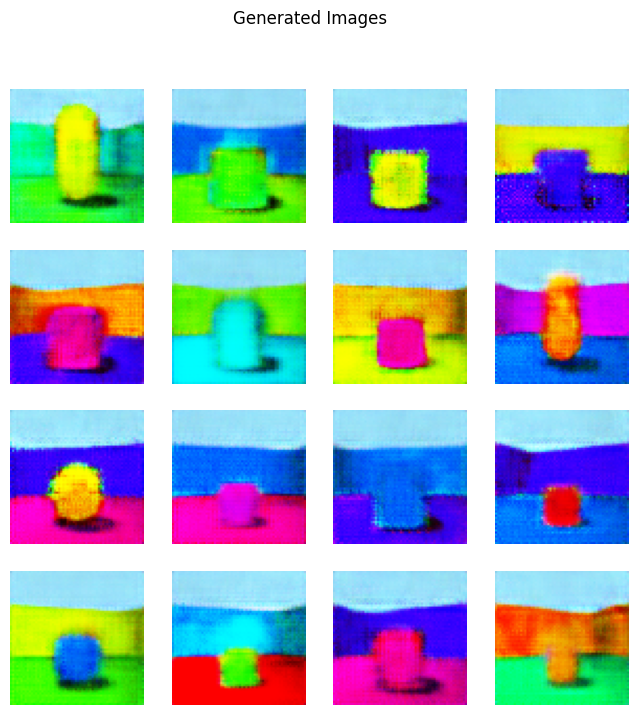

In [6]:
import matplotlib.pyplot as plt

# Generate some fake images for visualization
num_images_to_show = 16
z_sample = torch.randn(num_images_to_show, gen.latent_dim).to(device)
with torch.no_grad():
    generated_images = gen(z_sample).cpu()

# Plot the generated images
fig = plt.figure(figsize=(8, 8))
for i in range(num_images_to_show):
    ax = fig.add_subplot(4, 4, i + 1)
    img = generated_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle("Generated Images")
plt.show()

## DSprites

In [10]:
# Load DSprites dataset
DSprites = get_dataset("dsprites")
dsprites_dataset = DSprites(selected_factors='all', not_selected_factors_index_value=None)

num_workers_dsprites = 4
dsprites_data_loader = DataLoader(dsprites_dataset, 
                                 batch_size=64, 
                                 shuffle=True, 
                                 num_workers=num_workers_dsprites, 
                                 pin_memory=True,
                                 persistent_workers=True
                                 )

In [13]:
# Initialize Generator and Discriminator for DSprites using the same classes
dsprites_img_size = (1, 64, 64)  # Single-channel images of size 64x64
dsprites_gen = Generator(dsprites_img_size, latent_dim=10).to(device)
dsprites_disc = Discriminator(dsprites_img_size).to(device)

# Optimizers for DSprites models
dsprites_gen_optimizer = torch.optim.Adam(dsprites_gen.parameters(), lr=0.0001, betas=(0.5, 0.9))
dsprites_disc_optimizer = torch.optim.Adam(dsprites_disc.parameters(), lr=0.0001, betas=(0.5, 0.9))

# Training parameters
num_epochs_dsprites = 10
critic_iterations = 5  # Discriminator steps per generator step
lambda_gp = 10  # Gradient penalty lambda

print("Starting DSprites WGAN-GP Training...")

# Training Loop for DSprites
for epoch in range(num_epochs_dsprites):
    progress_bar = tqdm(dsprites_data_loader, desc=f"DSprites Epoch {epoch+1}/{num_epochs_dsprites}")
    for i, (real_images, _) in enumerate(progress_bar):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Discriminator
        for _ in range(critic_iterations):
            dsprites_disc_optimizer.zero_grad()
            
            # Real images
            real_output = dsprites_disc(real_images)
            
            # Fake images
            z = torch.randn(batch_size, dsprites_gen.latent_dim).to(device)
            fake_images = dsprites_gen(z).detach()
            fake_output = dsprites_disc(fake_images)
            
            # Calculate gradient penalty
            gp = calculate_gradient_penalty(dsprites_disc, real_images, fake_images, device)
            
            # Discriminator loss
            d_loss = -torch.mean(real_output) + torch.mean(fake_output) + lambda_gp * gp
            d_loss.backward()
            dsprites_disc_optimizer.step()
            
        # Train Generator
        dsprites_gen_optimizer.zero_grad()
        z = torch.randn(batch_size, dsprites_gen.latent_dim).to(device)
        fake_images = dsprites_gen(z)
        output = dsprites_disc(fake_images)
        g_loss = -torch.mean(output)  # Generator tries to make fake images look real
        g_loss.backward()
        dsprites_gen_optimizer.step()
            
        # Update tqdm postfix with current losses
        if (i+1) % 100 == 0:
            progress_bar.set_postfix(D_Loss=d_loss.item(), G_Loss=g_loss.item())

print("DSprites training complete!")

Starting DSprites WGAN-GP Training...


DSprites Epoch 1/10:   0%|          | 0/11520 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 237, 245, 253, 261) exited unexpectedly

In [ ]:
# Generate and visualize DSprites fake images
num_images_to_show = 16
z_sample = torch.randn(num_images_to_show, dsprites_gen.latent_dim).to(device)
with torch.no_grad():
    dsprites_generated_images = dsprites_gen(z_sample).cpu()

# Plot the generated DSprites images
fig = plt.figure(figsize=(8, 8))
for i in range(num_images_to_show):
    ax = fig.add_subplot(4, 4, i + 1)
    # For single-channel images, squeeze the channel dimension and use grayscale colormap
    img = dsprites_generated_images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle("Generated DSprites Images")
plt.show()

In [ ]:
# Compare real vs generated DSprites images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

# Get a batch of real images
real_batch = next(iter(dsprites_data_loader))[0][:8]

# Generate fake images
with torch.no_grad():
    z_sample = torch.randn(8, dsprites_gen.latent_dim).to(device)
    fake_batch = dsprites_gen(z_sample).cpu()

# Plot real images (top row)
for i in range(8):
    axes[0, i].imshow(real_batch[i].squeeze().numpy(), cmap='gray')
    axes[0, i].set_title('Real' if i == 0 else '')
    axes[0, i].axis('off')

# Plot generated images (bottom row)
for i in range(8):
    axes[1, i].imshow(fake_batch[i].squeeze().numpy(), cmap='gray')
    axes[1, i].set_title('Generated' if i == 0 else '')
    axes[1, i].axis('off')

plt.suptitle("Real vs Generated DSprites Images")
plt.tight_layout()
plt.show()